# Examen de cinturón AML – Opción A
**Descripción del examen:**

En este examen, trabajarás con un dataset reciente de complejidad baja, donde primero realizarás un análisis no supervisado utilizando K-means o PCA, y luego modelarás el conjunto de datos utilizando un Perceptrón Multicapa (MLP). El objetivo es aplicar técnicas de clustering o reducción de dimensionalidad para analizar los datos, seguido de la implementación de un modelo MLP para realizar predicciones.

**Dataset:**

El dataset utilizado para este examen es el «Customer Personality Analysis» disponible en Kaggle. Este conjunto de datos contiene información demográfica y de comportamiento de clientes, con el objetivo de agruparlos y predecir sus patrones de compra.
Enlace al dataset: https://www.kaggle.com/imakash3011/customer-personality-analysis

##Funciones a utilizar

In [1]:
# Función para encontrar valores atípicos POR el método de los cuartiles y el rango intercuartílico (IQR). chatgpt
def identificar_atipicos_IQR(df, columnas):
    atipicos = pd.DataFrame()  # DataFrame para almacenar filas con valores atípicos

    for columna in columnas:
        # Calcular Q1, Q3 y IQR
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1

        # Definir límites para valores atípicos
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Filtrar filas que tienen valores atípicos
        filas_atipicas = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

        # Concatenar filas atípicas al DataFrame de atípicos
        atipicos = pd.concat([atipicos, filas_atipicas])

    return atipicos.drop_duplicates()  # Eliminar duplicados
def ver_resumen_nulos(df):
    qna=df.isnull().sum(axis=0)
    qsna=df.shape[0]-qna

    ppna=round(100*(qna/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    resumen_nulos =na.sort_values(by='Na en %',ascending=False)
    return resumen_nulos
def desc(df, columns=None):
    """
    Genera un cuadro de estadísticas descriptivas con el porcentaje de std/mean incluido.

    Parameters:
    df (pd.DataFrame): El DataFrame a analizar.
    columns (list): Lista de columnas sobre las cuales aplicar el cálculo. Si es None, se incluyen todas las columnas numéricas.

    Returns:
    pd.DataFrame: DataFrame con estadísticas descriptivas y el porcentaje std/mean.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns  # Seleccionar todas las columnas numéricas si no se especifican

    # Generar el describe solo para las columnas seleccionadas
    df_describe = df[columns].describe().T

    # Calcular y agregar la columna del porcentaje std/mean
    df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

    return df_describe

def desc_ceros(df, columns=None):
    """
    Genera un cuadro de estadísticas descriptivas filtrando columnas con mínimo o máximo igual a cero,
    e incluye el porcentaje de std/mean.

    Parameters:
    df (pd.DataFrame): El DataFrame a analizar.
    columns (list): Lista de columnas sobre las cuales aplicar el cálculo. Si es None, se incluyen todas las columnas numéricas.

    Returns:
    pd.DataFrame: DataFrame con estadísticas descriptivas y el porcentaje std/mean para las columnas filtradas.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns  # Seleccionar todas las columnas numéricas si no se especifican

    # Generar el describe solo para las columnas seleccionadas
    df_describe = df[columns].describe().T

    # Calcular y agregar la columna del porcentaje std/mean
    df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

    # Filtrar las columnas donde el mínimo o el máximo sea igual a cero
    df_describe = df_describe[(df_describe['min'] == 0) | (df_describe['max'] == 0)]

    return df_describe
def imprimir_bigotes(serie):
    """
    Calcula e imprime los bigotes de una serie de datos.

    Parameters:
    serie (pd.Series): La serie de datos para la cual se calcularán los bigotes.

    Returns:
    None: Imprime los valores de los bigotes.
    """
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los bigotes
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print(f"Límite inferior (bigote inferior): {limite_inferior}")
    print(f"Límite superior (bigote superior): {limite_superior}")
    # Retornar los valores para poder usarlos en otras funciones
    return limite_inferior, limite_superior
def imprimir_bigotes_por_grupo(df, columna, target):
    """
    Imprime los bigotes de los datos por grupo de una columna específica.

    Parameters:
    df (pd.DataFrame): El DataFrame con los datos.
    columna (str): La columna sobre la que se calcularán los bigotes.
    target (str): La columna que contiene las etiquetas de grupo (por ejemplo, 'Species').

    Returns:
    None: Imprime los bigotes por cada grupo.
    """
    print(f"\nBigotes de {columna} por grupo:")
    for species in df[target].unique():
        print(f"\nEspecie: {species}")
        species_data = df[df[target] == species][columna]
        # Imprimir los bigotes solo una vez
        limite_inferior, limite_superior = imprimir_bigotes(species_data)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
def plot_varianza(prm_pca,varianza_minima=90):
    plt.figure(figsize=(12, 6))

    # 1. Ganancia de varianza explicada por cada componente
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(prm_pca.explained_variance_ratio_) + 1),
            prm_pca.explained_variance_ratio_, color='skyblue')
    plt.title('Ganancia de varianza explicada por cada componente')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Ganancia de Varianza Explicada (%)')
    plt.grid(True)

    # Etiquetas en las barras
    for i, v in enumerate(prm_pca.explained_variance_ratio_):
        plt.text(i + 1, v + 0.01, f'{v*100:.2f}%', ha='center')

    # 2. Varianza acumulada
    explained_variance_cumulative = prm_pca.explained_variance_ratio_.cumsum()
    explained_variance_gain = np.diff(explained_variance_cumulative, prepend=0)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(explained_variance_cumulative) + 1),
             explained_variance_cumulative, marker='o', linestyle='--', color='orange')
    plt.title('Variación Explicada Acumulada')
    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Varianza Explicada Acumulada')
    plt.axhline(y=varianza_minima, color='r', linestyle='--', label=f'{varianza_minima*100}% Umbral')
    plt.axvline(x=np.argmax(explained_variance_cumulative >= varianza_minima) + 1,
                color='g', linestyle='--', label='Número óptimo de componentes')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Mostrar información en consola
    print("Variación explicada acumulada y ganancia:")
    for i, variance in enumerate(explained_variance_cumulative, 1):
        variance_rounded = round(variance, 4)
        print(f"variance_rounded: {variance_rounded}")
        if variance_rounded < 1:
            print(f"Componente {i}: {variance:.2%} ({explained_variance_gain[i-1]*100:.2f}%)")
        else:
          print(f"Existen mas componentes pero ya no aportan variabilidad significativa o es muy infima.")
          break

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)




In [2]:
import pandas as pd
# Acceder al archivo
file_path = '/marketing_campaign.csv'
df_train = pd.read_csv(file_path, sep='\t')
print(df_train.head())

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

In [3]:
# Copiamos el dataset al df para trabajarlo
df = df_train.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
# Diccionario
import pandas as pd

# Crear una lista con la información del diccionario de datos
data_dict = [
    # Grupo: People
    ["ID", "int64", "Identificador único del cliente", "12345", "People"],
    ["Year_Birth", "int64", "Año de nacimiento del cliente", "1985", "People"],
    ["Education", "object", "Nivel educativo del cliente", "Graduado", "People"],
    ["Marital_Status", "object", "Estado civil del cliente", "Casado", "People"],
    ["Income", "float64", "Ingreso anual del hogar del cliente", "50000", "People"],
    ["Kidhome", "int64", "Número de niños en el hogar del cliente", "1", "People"],
    ["Teenhome", "int64", "Número de adolescentes en el hogar del cliente", "0", "People"],
    ["Dt_Customer", "datetime64", "Fecha de registro del cliente en la empresa", "2019-01-01", "People"],
    ["Recency", "int64", "Días desde la última compra del cliente", "10", "People"],
    ["Complain", "int64", "1 si el cliente se quejó en los últimos 2 años, 0 en caso contrario", "0", "People"],

    # Grupo: Products
    ["MntWines", "float64", "Monto gastado en vino en los últimos 2 años", "300", "Products"],
    ["MntFruits", "float64", "Monto gastado en frutas en los últimos 2 años", "50", "Products"],
    ["MntMeatProducts", "float64", "Monto gastado en carne en los últimos 2 años", "200", "Products"],
    ["MntFishProducts", "float64", "Monto gastado en pescado en los últimos 2 años", "75", "Products"],
    ["MntSweetProducts", "float64", "Monto gastado en dulces en los últimos 2 años", "30", "Products"],
    ["MntGoldProds", "float64", "Monto gastado en productos de oro en los últimos 2 años", "20", "Products"],

    # Grupo: Promotion
    ["NumDealsPurchases", "int64", "Número de compras realizadas con descuento", "5", "Promotion"],
    ["AcceptedCmp1", "int64", "1 si el cliente aceptó la oferta de la primera campaña, 0 en caso contrario", "0", "Promotion"],
    ["AcceptedCmp2", "int64", "1 si el cliente aceptó la oferta de la segunda campaña, 0 en caso contrario", "0", "Promotion"],
    ["AcceptedCmp3", "int64", "1 si el cliente aceptó la oferta de la tercera campaña, 0 en caso contrario", "0", "Promotion"],
    ["AcceptedCmp4", "int64", "1 si el cliente aceptó la oferta de la cuarta campaña, 0 en caso contrario", "0", "Promotion"],
    ["AcceptedCmp5", "int64", "1 si el cliente aceptó la oferta de la quinta campaña, 0 en caso contrario", "1", "Promotion"],
    ["Response", "int64", "1 si el cliente aceptó la oferta de la última campaña, 0 en caso contrario", "1", "Promotion"],

    # Grupo: Place
    ["NumWebPurchases", "int64", "Número de compras realizadas a través del sitio web", "3", "Place"],
    ["NumCatalogPurchases", "int64", "Número de compras realizadas usando un catálogo", "2", "Place"],
    ["NumStorePurchases", "int64", "Número de compras realizadas directamente en tiendas", "4", "Place"],
    ["NumWebVisitsMonth", "int64", "Número de visitas al sitio web en el último mes", "7", "Place"],

    # Grupo: Costs
    ["CostContact", "float64", "Costo de contactar al cliente", "1.5", "Costs"],

    # Grupo: Revenue
    ["Revenue", "float64", "Ingresos generados por el cliente", "120.75", "Revenue"],
]

# Crear el DataFrame
df_diccionario = pd.DataFrame(data_dict, columns=["Columna", "Tipo", "Descripción", "Ejemplo", "Grupo"])

In [6]:
df_diccionario

,Columna,Tipo,Descripción,Ejemplo,Grupo
0,ID,int64,Identificador único del cliente,12345,People
1,Year_Birth,int64,Año de nacimiento del cliente,1985,People
2,Education,object,Nivel educativo del cliente,Graduado,People
3,Marital_Status,object,Estado civil del cliente,Casado,People
4,Income,float64,Ingreso anual del hogar del cliente,50000,People
5,Kidhome,int64,Número de niños en el hogar del cliente,1,People
6,Teenhome,int64,Número de adolescentes en el hogar del cliente,0,People
7,Dt_Customer,datetime64,Fecha de registro del cliente en la empresa,2019-01-01,People
8,Recency,int64,Días desde la última compra del cliente,10,People
9,Complain,int64,1 si el cliente se quejó en los últimos 2 años...,0,People


In [7]:
# Detectar columnas con valores únicos ['Yes', 'No']
yes_no_columns = [col for col in df.columns if sorted(df[col].dropna().unique()) == ['No', 'Yes']]
print("Columnas con valores 'Yes' y 'No':", yes_no_columns)
# Aplicar el mapeo 'Yes' -> 1 y 'No' -> 0 a todas las columnas de una vez usando map y itertools
df[yes_no_columns] = pd.DataFrame(
    map(lambda col: df[col].map({'Yes': 1, 'No': 0}), yes_no_columns)
).T.set_axis(yes_no_columns, axis=1)

Columnas con valores 'Yes' y 'No': []


In [8]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
Income,2216,24,1.07
ID,2240,0,0.00
NumDealsPurchases,2240,0,0.00
Z_Revenue,2240,0,0.00
Z_CostContact,2240,0,0.00
Complain,2240,0,0.00
AcceptedCmp2,2240,0,0.00
AcceptedCmp1,2240,0,0.00
AcceptedCmp5,2240,0,0.00
AcceptedCmp4,2240,0,0.00


Tenenos nulos en income

In [9]:
# Ver los registros de Icome nulos
df[df['Income'].isnull()]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
10,1994,1983,Graduation,Married,NaN,1,0,15-11-2013,11,5,...,7,0,0,0,0,0,0,3,11,0
27,5255,1986,Graduation,Single,NaN,1,0,20-02-2013,19,5,...,1,0,0,0,0,0,0,3,11,0
43,7281,1959,PhD,Single,NaN,0,0,05-11-2013,80,81,...,2,0,0,0,0,0,0,3,11,0
48,7244,1951,Graduation,Single,NaN,2,1,01-01-2014,96,48,...,6,0,0,0,0,0,0,3,11,0
58,8557,1982,Graduation,Single,NaN,1,0,17-06-2013,57,11,...,6,0,0,0,0,0,0,3,11,0
71,10629,1973,2n Cycle,Married,NaN,1,0,14-09-2012,25,25,...,8,0,0,0,0,0,0,3,11,0
90,8996,1957,PhD,Married,NaN,2,1,19-11-2012,4,230,...,9,0,0,0,0,0,0,3,11,0
91,9235,1957,Graduation,Single,NaN,1,1,27-05-2014,45,7,...,7,0,0,0,0,0,0,3,11,0
92,5798,1973,Master,Together,NaN,0,0,23-11-2013,87,445,...,1,0,0,0,0,0,0,3,11,0
128,8268,1961,PhD,Married,NaN,0,1,11-07-2013,23,352,...,6,0,0,0,0,0,0,3,11,0


In [10]:
# Ver estadisticas por Education
df.groupby('Education')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Education,,,,,,,,
2n Cycle,200.0,47633.190000,22119.081838,7500.0,27526.50,46805.0,65393.25,96547.0
Basic,54.0,20306.259259,6235.066773,7500.0,15405.25,20744.0,24882.00,34445.0
Graduation,1116.0,52720.373656,28177.192681,1730.0,34834.50,52028.5,69930.50,666666.0
Master,365.0,52917.534247,20157.788029,6560.0,37760.00,50943.0,66726.00,157733.0
PhD,481.0,56145.313929,20612.979997,4023.0,40451.00,55212.0,69098.00,162397.0


In [11]:
# Aplicar la moda del Icome agrupado por Education SOLO para los que tienen nulos.
df.loc[df['Income'].isnull(), 'Income'] = df.groupby('Education')['Income'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)


In [12]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
ID,2240,0,0.0
NumDealsPurchases,2240,0,0.0
Z_Revenue,2240,0,0.0
Z_CostContact,2240,0,0.0
Complain,2240,0,0.0
AcceptedCmp2,2240,0,0.0
AcceptedCmp1,2240,0,0.0
AcceptedCmp5,2240,0,0.0
AcceptedCmp4,2240,0,0.0
AcceptedCmp3,2240,0,0.0


Ya no tenemos nulos.

In [13]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


In [14]:
# Convertir Dt_Customer a datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')

# Verificar los tipos de datos después de la conversión
print(df.dtypes)


ID                              int64
Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Complain                        int64
Z_CostContac

In [15]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
Dt_Customer,916,1324,59.11
ID,2240,0,0.00
NumDealsPurchases,2240,0,0.00
Z_Revenue,2240,0,0.00
Z_CostContact,2240,0,0.00
Complain,2240,0,0.00
AcceptedCmp2,2240,0,0.00
AcceptedCmp1,2240,0,0.00
AcceptedCmp5,2240,0,0.00
AcceptedCmp4,2240,0,0.00


In [16]:
#Dt_Customer tiene mas del 50% nulos, voy a eliminarlo porque son demasiados como para inputacion.
df.drop('Dt_Customer', axis=1, inplace=True)

In [18]:
# Estos estados Alone, Absurd y YOLO los voy a cambiar a Single.
df.loc[df['Marital_Status'].isin(['Alone', 'Absurd', 'YOLO']), 'Marital_Status'] = 'Single'

In [19]:
# Identificar columnas de tipo 'object', típicamente usadas para variables categóricas
categorical_columns = df.select_dtypes(include=['object','bool']).columns
# Crear un diccionario donde cada clave es el nombre de la columna y los valores son los valores únicos de esa columna
unique_values_dict = {col: df[col].unique() for col in categorical_columns}
# Convertir el diccionario en un DataFrame, rellenando con NaN cuando haya menos valores únicos
unique_values_df = pd.DataFrame.from_dict(unique_values_dict, orient='index').transpose()
# Mostrar el DataFrame resultante
unique_values_df.T

,0,1,2,3,4
Education,Graduation,PhD,Master,Basic,2n Cycle
Marital_Status,Single,Together,Married,Divorced,Widow


In [20]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
ID,2240,0,0.0
Year_Birth,2240,0,0.0
Z_Revenue,2240,0,0.0
Z_CostContact,2240,0,0.0
Complain,2240,0,0.0
AcceptedCmp2,2240,0,0.0
AcceptedCmp1,2240,0,0.0
AcceptedCmp5,2240,0,0.0
AcceptedCmp4,2240,0,0.0
AcceptedCmp3,2240,0,0.0


**Reloaded: Ya no hay nulos.**

In [22]:
# Obtener todas las columnas numéricas
numeric_columns = df.select_dtypes(include=['number']).columns

# Excluir las columnas específicas
columns_to_exclude = ['ID', 'Z_Revenue', 'Z_CostContact']
numeric_columns = [col for col in numeric_columns if col not in columns_to_exclude]

# Verificar las columnas numéricas después de la exclusión
print(numeric_columns)


['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']


In [23]:
# Necesito calcular la Edad en base Year_Birth
df['Age'] = 2024 - df['Year_Birth']

In [24]:
identificar_atipicos_IQR(df,numeric_columns)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,99,15,6,...,0,0,0,0,0,1,3,11,0,124
239,11004,1893,2n Cycle,Single,60182.0,0,1,23,8,0,...,0,0,0,0,0,0,3,11,0,131
339,1150,1899,PhD,Together,83532.0,0,0,36,755,144,...,0,0,1,0,0,0,3,11,0,125
164,8475,1973,PhD,Married,157243.0,0,1,98,20,2,...,0,0,0,0,0,0,3,11,0,51
617,1503,1976,PhD,Together,162397.0,1,1,31,85,1,...,0,0,0,0,0,0,3,11,0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,1241,1984,2n Cycle,Married,14796.0,1,0,1,13,3,...,0,0,0,0,0,0,3,11,1,40
2128,1631,1965,PhD,Together,65220.0,0,0,3,890,63,...,0,0,0,0,0,0,3,11,1,59
2139,2715,1966,Master,Divorced,29435.0,1,1,11,70,3,...,0,0,0,0,0,0,3,11,1,58
2202,11133,1973,PhD,Single,48432.0,0,1,3,322,3,...,0,0,0,0,0,0,3,11,1,51


In [25]:
desc(df,'Year_Birth')

,Year_Birth
count,2240.000000
mean,1968.805804
std,11.984069
min,1893.000000
25%,1959.000000
50%,1970.000000
75%,1977.000000
max,1996.000000
%std/mean,0.610000


Los outliers de edad voy a imputar. No los voy a eliminar.

In [26]:
# A todos los highlander le pondremos la moda de la edad para preservar sus identidades y no le corten las cabezas.
#A Todos los registros que tengan Year_Birth menores 1930 asignarle 1977.
df.loc[df['Year_Birth'] < 1930, 'Year_Birth'] = 1977


In [27]:
desc(df,'Year_Birth')

,Year_Birth
count,2240.000000
mean,1968.912500
std,11.697827
min,1940.000000
25%,1959.000000
50%,1970.000000
75%,1977.000000
max,1996.000000
%std/mean,0.590000


Bien, ya todos estan a salvo y puedo continuar con mi examen.

In [28]:
identificar_atipicos_IQR(df,numeric_columns)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
164,8475,1973,PhD,Married,157243.0,0,1,98,20,2,...,0,0,0,0,0,0,3,11,0,51
617,1503,1976,PhD,Together,162397.0,1,1,31,85,1,...,0,0,0,0,0,0,3,11,0,48
655,5555,1975,Graduation,Divorced,153924.0,0,0,81,1,1,...,0,0,0,0,0,0,3,11,0,49
687,1501,1982,PhD,Married,160803.0,0,0,21,55,16,...,0,0,0,0,0,0,3,11,0,42
1300,5336,1971,Master,Together,157733.0,1,0,37,39,1,...,0,0,0,0,0,0,3,11,0,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,1241,1984,2n Cycle,Married,14796.0,1,0,1,13,3,...,0,0,0,0,0,0,3,11,1,40
2128,1631,1965,PhD,Together,65220.0,0,0,3,890,63,...,0,0,0,0,0,0,3,11,1,59
2139,2715,1966,Master,Divorced,29435.0,1,1,11,70,3,...,0,0,0,0,0,0,3,11,1,58
2202,11133,1973,PhD,Single,48432.0,0,1,3,322,3,...,0,0,0,0,0,0,3,11,1,51


In [29]:
#Quienes tienen Income cero
df[df['Income']==0]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age


In [30]:
#Quienes tiene Income negativo
df[df['Income']<0]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age


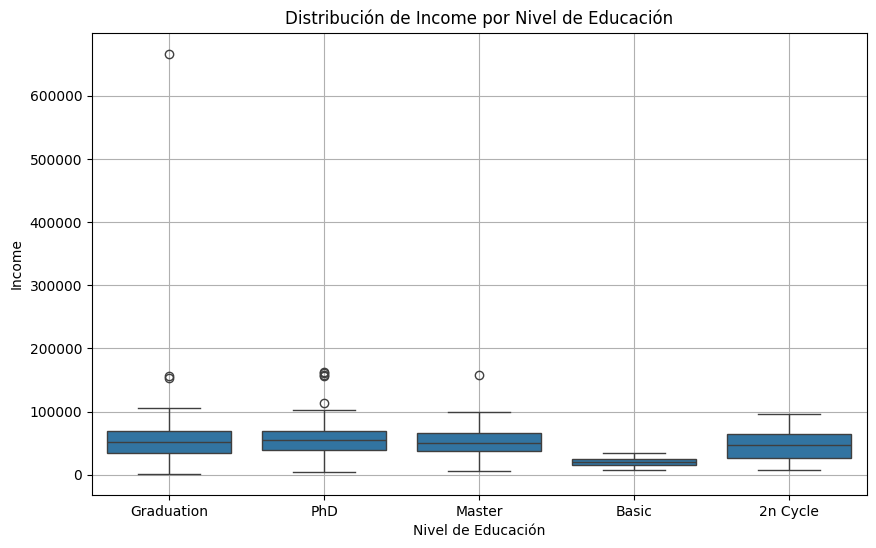

             count          mean           std     min       25%      50%  \
Education                                                                   
2n Cycle     203.0  47040.088670  22484.550489  7500.0  26897.00  46772.0   
Basic         54.0  20306.259259   6235.066773  7500.0  15405.25  20744.0   
Graduation  1127.0  52279.003549  28389.780560  1730.0  34593.50  51651.0   
Master       370.0  52825.378378  20036.270916  6560.0  37853.75  50183.5   
PhD          486.0  55936.617284  20608.569717  4023.0  39821.25  55005.0   

                75%       max  
Education                      
2n Cycle    65100.5   96547.0  
Basic       24882.0   34445.0  
Graduation  69737.0  666666.0  
Master      66596.0  157733.0  
PhD         69084.0  162397.0  


In [31]:
#Quiero ver un boxplot y barras de distro de Incoming
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Education', y='Income')
plt.title('Distribución de Income por Nivel de Educación')
plt.xlabel('Nivel de Educación')
plt.ylabel('Income')
plt.grid(True)
plt.show()

# Descripción estadística de Income por Education
descripcion = df.groupby('Education')['Income'].describe()
print(descripcion)


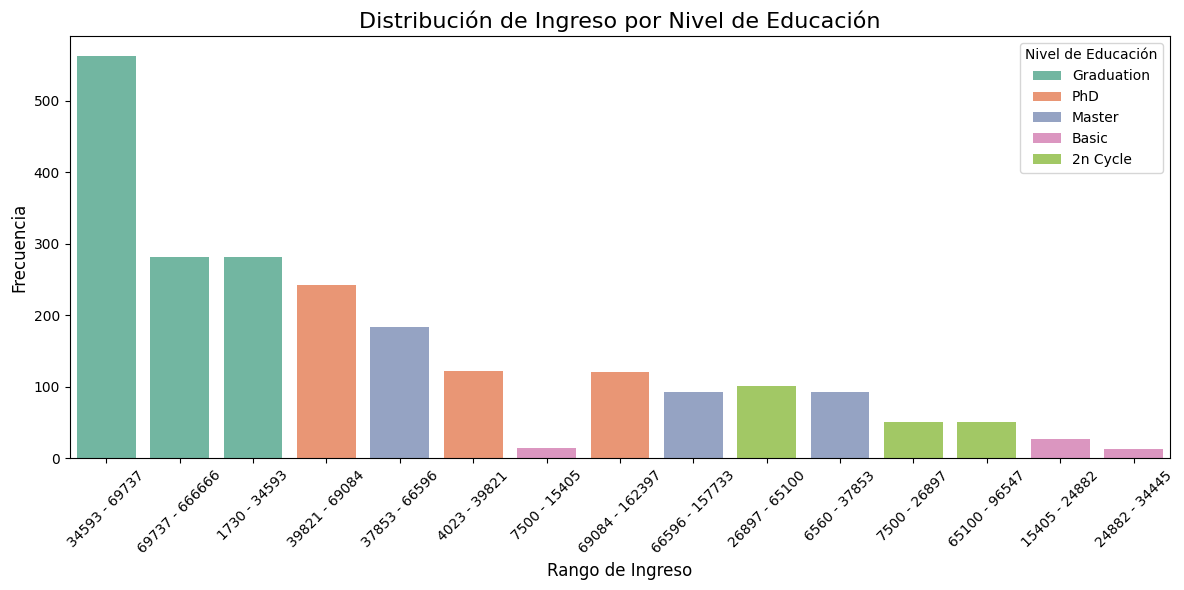

    Education   Income Income_Category
0  Graduation  58138.0   34593 - 69737
1  Graduation  46344.0   34593 - 69737
2  Graduation  71613.0  69737 - 666666
3  Graduation  26646.0    1730 - 34593
4         PhD  58293.0   39821 - 69084


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calcular el IQR (rango intercuartílico) para 'Income' por cada grupo de 'Education'
def calculate_income_bins(df, education_group):
    income_group = df[df['Education'] == education_group]['Income']
    Q1 = income_group.quantile(0.25)
    Q3 = income_group.quantile(0.75)
    IQR = Q3 - Q1

    # Obtener el valor mínimo de 'Income' en el grupo de educación
    min_income = income_group.min()

    # Definir los rangos de ingresos según el IQR para este grupo
    bins = [min_income, Q1, Q1 + IQR, Q3 + 1e-6, income_group.max()]
    bin_labels = [f"{int(bins[i])} - {int(bins[i+1])}" for i in range(len(bins)-1)]  # Crear etiquetas de rangos
    return bins, bin_labels

# Crear una columna para el rango de 'Income' para cada grupo de 'Education'
df['Income_Category'] = None

for education_group in df['Education'].unique():
    bins, bin_labels = calculate_income_bins(df, education_group)
    df.loc[df['Education'] == education_group, 'Income_Category'] = pd.cut(df[df['Education'] == education_group]['Income'], bins=bins, labels=bin_labels, include_lowest=True)

# Crear un gráfico de barras para mostrar la frecuencia de cada rango de 'Income' por 'Education'
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Income_Category', hue='Education', palette='Set2')

# Personalizar el gráfico
plt.title('Distribución de Ingreso por Nivel de Educación', fontsize=16)
plt.xlabel('Rango de Ingreso', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Nivel de Educación')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Mostrar las primeras filas del DataFrame para verificar la nueva columna 'Income_Category'
print(df[['Education', 'Income', 'Income_Category']].head())


Use un boxplot y grafico de barras para identificar los outliers y como se ven en cifras y frecuencias.

Las cifras agrupe por el rango intercuartilico para mejor exposición

Se puede ver que tenemos un Graduado que gana un poco mas de 650mil dolares (futuro dueño de un unicornio?)

Los de Educacion 2n Cycle y Basi tienen el mismo minimo de ingresos pero no así el maximo.
Hay del 2n Cycle que ganan mas de 95mil dolares superando a los de niveles superiores: Posiblemente trabajen en ventas o algo que tenga que ver con habilidades blandas.

Estos Outliers no los voy a elimninar, son parte de la realidad.

**Me falta analizar lo referente a Edad y en que gastan mas.**

Education           5
Marital_Status      5
Income_Category    15
dtype: int64

Frecuencia de valores para Education:
Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

Frecuencia de valores para Marital_Status:
Marital_Status
Married     864
Together    580
Single      487
Divorced    232
Widow        77
Name: count, dtype: int64

Frecuencia de valores para Income_Category:
Income_Category
34593 - 69737     563
69737 - 666666    282
1730 - 34593      282
39821 - 69084     243
37853 - 66596     184
4023 - 39821      122
69084 - 162397    121
26897 - 65100     101
66596 - 157733     93
6560 - 37853       93
7500 - 26897       51
65100 - 96547      51
15405 - 24882      27
7500 - 15405       14
24882 - 34445      13
Name: count, dtype: int64


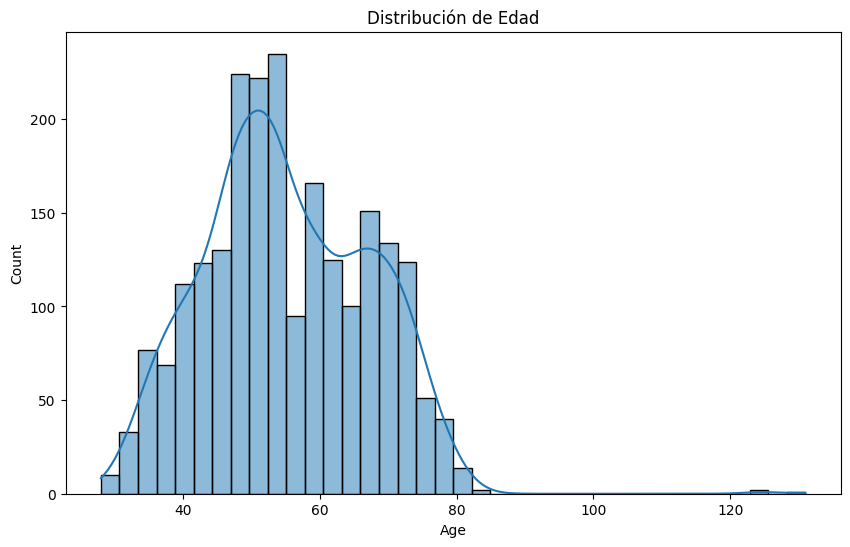

<Figure size 1000x600 with 0 Axes>

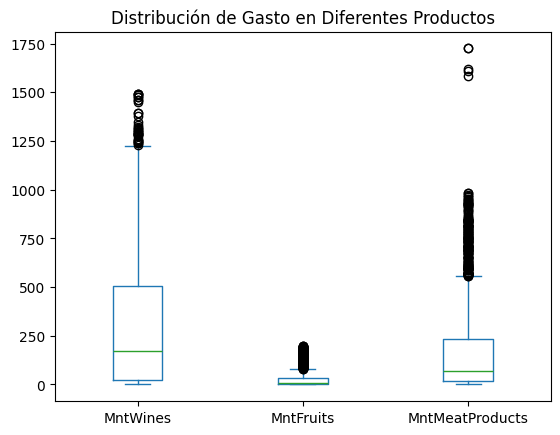

In [33]:
# Revisión de las variables categóricas
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns
print(df[categorical_columns].nunique())  # Número de categorías únicas por columna

# Estadísticas de frecuencia para variables categóricas
for col in categorical_columns:
    print(f"\nFrecuencia de valores para {col}:")
    print(df[col].value_counts())

# Visualización (opcional)
import seaborn as sns
import matplotlib.pyplot as plt

# Histograma de 'Age'
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True)
plt.title('Distribución de Edad')
plt.show()

# Comportamiento de compra (Ejemplo: cantidad gastada en productos)
plt.figure(figsize=(10, 6))
df[['MntWines', 'MntFruits', 'MntMeatProducts']].plot(kind='box')
plt.title('Distribución de Gasto en Diferentes Productos')
plt.show()


Los clientes en cuanto a edad, la mayoria tienen entre 48 y 52 años.

La mayoría de los clientes GASTAN mas en Carnes, Vinos y en menor proporción Frutas. No necesariamente consumen o compran mas Carnes.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2240 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

In [35]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Inicializar el codificador OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Aplicar el OneHotEncoder a las columnas 'Education' y 'Marital_Status'
encoded_data = encoder.fit_transform(df[['Education', 'Marital_Status']])

# Crear un DataFrame con las columnas codificadas
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Education', 'Marital_Status']))

# Concatenar el DataFrame original con las nuevas columnas codificadas
df = pd.concat([df, encoded_df], axis=1)

# Mostrar el DataFrame resultante
print(df.head())



     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

   Recency  MntWines  MntFruits  ...  Education_2n Cycle  Education_Basic  \
0       58       635         88  ...                 0.0              0.0   
1       38        11          1  ...                 0.0              0.0   
2       26       426         49  ...                 0.0              0.0   
3       26        11          4  ...                 0.0              0.0   
4       94       173         43  ...                 0.0              0.0   

   Education_Graduation  Education_Master  Education_PhD  \
0       

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       2240 non-null   int64  
 1   Year_Birth               2240 non-null   int64  
 2   Education                2240 non-null   object 
 3   Marital_Status           2240 non-null   object 
 4   Income                   2240 non-null   float64
 5   Kidhome                  2240 non-null   int64  
 6   Teenhome                 2240 non-null   int64  
 7   Recency                  2240 non-null   int64  
 8   MntWines                 2240 non-null   int64  
 9   MntFruits                2240 non-null   int64  
 10  MntMeatProducts          2240 non-null   int64  
 11  MntFishProducts          2240 non-null   int64  
 12  MntSweetProducts         2240 non-null   int64  
 13  MntGoldProds             2240 non-null   int64  
 14  NumDealsPurchases       

In [39]:
# Escalar los datos para tener media 0 y desviación estándar 1
# Voy a prescindir de una Year_Birth debido a que ya tengo Age.
# Income_Category voy a quitar porque no me va a aportar nada.
# Anteriormente quite otras columnas que no sirven como ID y Dt_Customer.
from sklearn.preprocessing import RobustScaler
X = df.drop(columns=['Year_Birth','Income_Category','ID','Z_Revenue','Z_CostContact','Education','Marital_Status'])
#y = df['Activity']
robustscaler = RobustScaler()
X_robustscaler = robustscaler.fit_transform(X)

# Mostrar un resumen de los datos escalados
print("Resumen de datos escalados:")
print(f"Media por característica (aproximadamente 0): {X_robustscaler.mean(axis=0)[:5]}")
print(f"Desviación estándar por característica (aproximadamente 1): {X_robustscaler.std(axis=0)[:5]}")

Resumen de datos escalados:
Media por característica (aproximadamente 0): [0.02526797 0.44419643 0.50625    0.0021875  0.2714583 ]
Desviación estándar por característica (aproximadamente 1): [0.75875976 0.53827791 0.54441667 0.57911975 0.70035848]


In [40]:
# Definir la variabilidad minima objetivo
variabilidad_minima = 0.90

In [41]:
# Standar Scaler.
# Escalar los datos para tener media 0 y desviación estándar 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mostrar un resumen de los datos escalados
print("Resumen de datos escalados:")
print(f"Media por característica (aproximadamente 0): {X_scaled.mean(axis=0)[:5]}")
print(f"Desviación estándar por característica (aproximadamente 1): {X_scaled.std(axis=0)[:5]}")

Resumen de datos escalados:
Media por característica (aproximadamente 0): [-6.42343321e-17 -1.58603289e-17 -3.17206578e-18 -3.17206578e-18
 -7.61295788e-17]
Desviación estándar por característica (aproximadamente 1): [1. 1. 1. 1. 1.]


**Con StandardScaler**

In [42]:
# Paso 2: Aplicar PCA con StandardScaler
#from sklearn.decomposition import PCA

pca = PCA(n_components=None)# Indica que se deja así para determinar el numero de componentes optimo. He Probado y funciona por eso lo uso.
pca.fit(X_scaled)# Aplicar PCA al dataset escalado
X_pca = pca.transform(X_scaled)

# Paso 3: Determinar cuántos componentes principales se necesitan para capturar al menos el 90% de la variabilidad
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Encontrar el número de componentes necesarios para capturar el 90% de la varianza
num_components = (cumulative_variance >= variabilidad_minima).argmax() + 1  # +1 porque los índices son base 0

# Mostrar el número de componentes y la varianza acumulada
print(f"Se necesitan {num_components} componentes para capturar al menos el 90% de la variabilidad.")
print(f"Varianza acumulada: {cumulative_variance[num_components - 1]:.4f}")

Se necesitan 22 componentes para capturar al menos el 90% de la variabilidad.
Varianza acumulada: 0.9025


**Con RobustScaler**

In [42]:
# Paso 2: Aplicar PCA con RobustScaler
RS_pca = PCA(n_components=15)# Indica que se deja así para determinar el numero de componentes optimo. He Probado y funciona por eso lo uso.
RS_pca.fit(X_robustscaler)# Aplicar PCA al dataset escalado
X_RS_pca = RS_pca.transform(X_robustscaler)

# Paso 3: Determinar cuántos componentes principales se necesitan para capturar al menos el 90% de la variabilidad
RS_cumulative_variance = RS_pca.explained_variance_ratio_.cumsum()

# Encontrar el número de componentes necesarios para capturar el 90% de la varianza
RS_num_components = (RS_cumulative_variance >= variabilidad_minima).argmax() + 1  # +1 porque los índices son base 0

# Mostrar el número de componentes y la varianza acumulada
print(f"Se necesitan {RS_num_components} componentes para capturar al menos el 90% de la variabilidad.")
print(f"Varianza acumulada: {RS_cumulative_variance[RS_num_components - 1]:.4f}")

Se necesitan 15 componentes para capturar al menos el 90% de la variabilidad.
Varianza acumulada: 0.9031


**Me quedo con RobustScaler. Menos componentes con un poco mas de variabilidad.**

Visualiza el gráfico de «explained variance» para mostrar cómo cada componente principal contribuye a la variabilidad total de los datos.

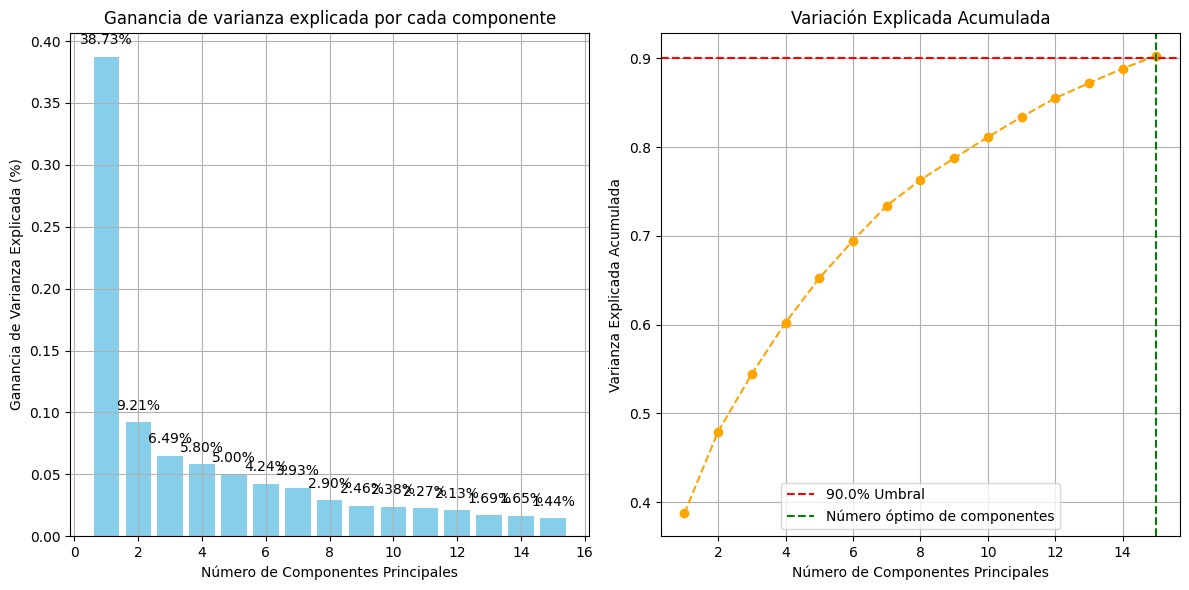

Variación explicada acumulada y ganancia:
variance_rounded: 0.3873
Componente 1: 38.73% (38.73%)
variance_rounded: 0.4794
Componente 2: 47.94% (9.21%)
variance_rounded: 0.5443
Componente 3: 54.43% (6.49%)
variance_rounded: 0.6023
Componente 4: 60.23% (5.80%)
variance_rounded: 0.6523
Componente 5: 65.23% (5.00%)
variance_rounded: 0.6947
Componente 6: 69.47% (4.24%)
variance_rounded: 0.734
Componente 7: 73.40% (3.93%)
variance_rounded: 0.763
Componente 8: 76.30% (2.90%)
variance_rounded: 0.7876
Componente 9: 78.76% (2.46%)
variance_rounded: 0.8114
Componente 10: 81.14% (2.38%)
variance_rounded: 0.8341
Componente 11: 83.41% (2.27%)
variance_rounded: 0.8553
Componente 12: 85.53% (2.13%)
variance_rounded: 0.8722
Componente 13: 87.22% (1.69%)
variance_rounded: 0.8887
Componente 14: 88.87% (1.65%)
variance_rounded: 0.9031
Componente 15: 90.31% (1.44%)


In [43]:
plot_varianza(RS_pca,variabilidad_minima)

# Proyecta los datos en los primeros componentes principales y visualiza cómo se agrupan los clientes en el nuevo espacio de características:

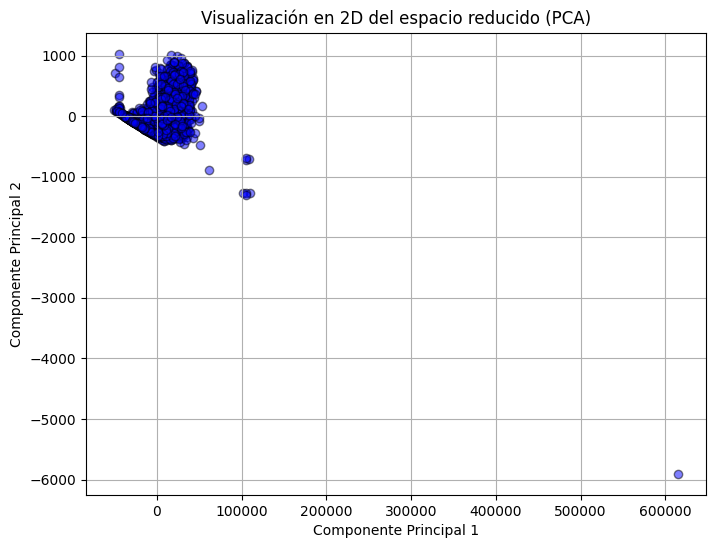

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Asumimos que 'X' es tu conjunto de datos original
# Realiza la reducción de dimensionalidad a 2 componentes principales
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Crear el gráfico de dispersión en 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5, c='blue', edgecolors='k')
plt.title('Visualización en 2D del espacio reducido (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

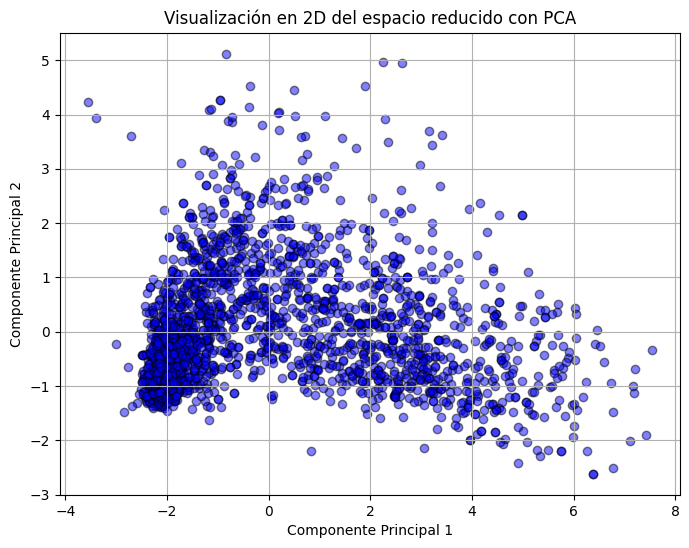

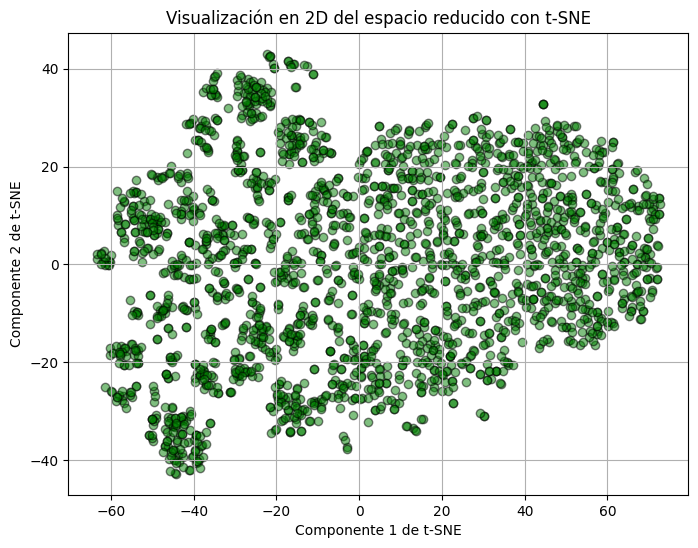

In [46]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Paso 1: Aplicar PCA al dataset escalado
RS_pca = PCA(n_components=2)
RS_X_reduced = RS_pca.fit_transform(X_robustscaler)

# Paso 2: Visualización en 2D usando PCA (para comparar con t-SNE)
plt.figure(figsize=(8, 6))
plt.scatter(RS_X_reduced[:, 0], RS_X_reduced[:, 1], alpha=0.5, c='blue', edgecolors='k')
plt.title('Visualización en 2D del espacio reducido con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

# Paso 3: Aplicar t-SNE sobre los datos escalados
tsne = TSNE(n_components=2, random_state=42)  # n_components=2 para visualización en 2D
X_tsne = tsne.fit_transform(X_robustscaler)

# Paso 4: Visualización en 2D usando t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, c='green', edgecolors='k')
plt.title('Visualización en 2D del espacio reducido con t-SNE')
plt.xlabel('Componente 1 de t-SNE')
plt.ylabel('Componente 2 de t-SNE')
plt.grid(True)
plt.show()


In [47]:
# Crear un DataFrame con los coeficientes
componentes_df = pd.DataFrame(
    data=np.abs(RS_pca.components_),  # Usamos el valor absoluto para interpretar magnitudes
    columns=X.columns,            # Nombres de las variables originales
    index=[f'PC{i+1}' for i in range(RS_pca.n_components_)]  # Nombres de los componentes principales
)

# Ordenar las variables más influyentes por componente principal
for pc in componentes_df.index:
    print(f"\nVariables más influyentes en {pc}:")
    print(componentes_df.loc[pc].sort_values(ascending=False).head(5))


Variables más influyentes en PC1:
MntSweetProducts    0.442295
MntFruits           0.425974
MntFishProducts     0.402096
MntMeatProducts     0.356025
MntGoldProds        0.287870
Name: PC1, dtype: float64

Variables más influyentes en PC2:
NumDealsPurchases    0.685446
MntGoldProds         0.423673
NumWebPurchases      0.325559
Teenhome             0.245011
MntWines             0.185710
Name: PC2, dtype: float64


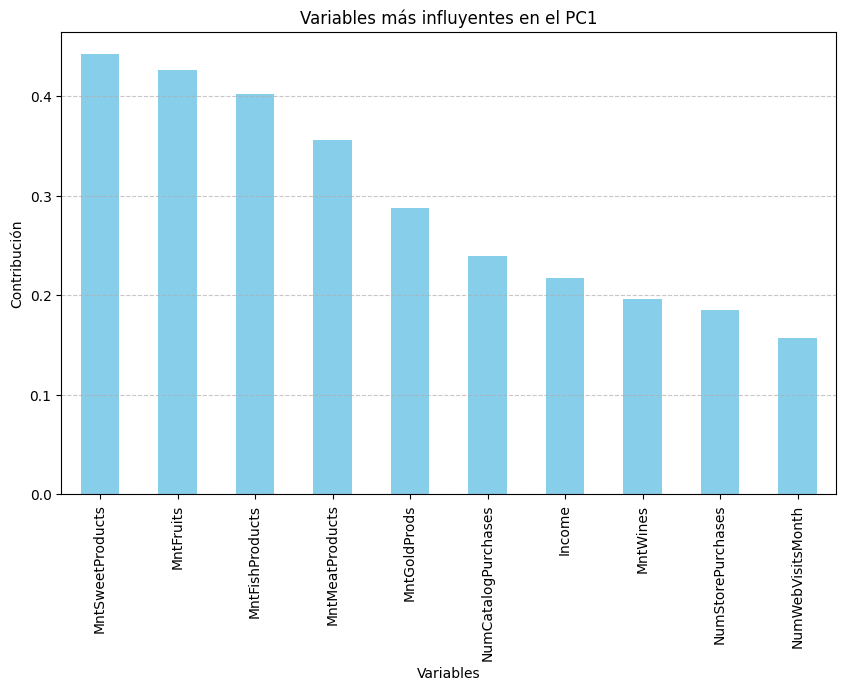

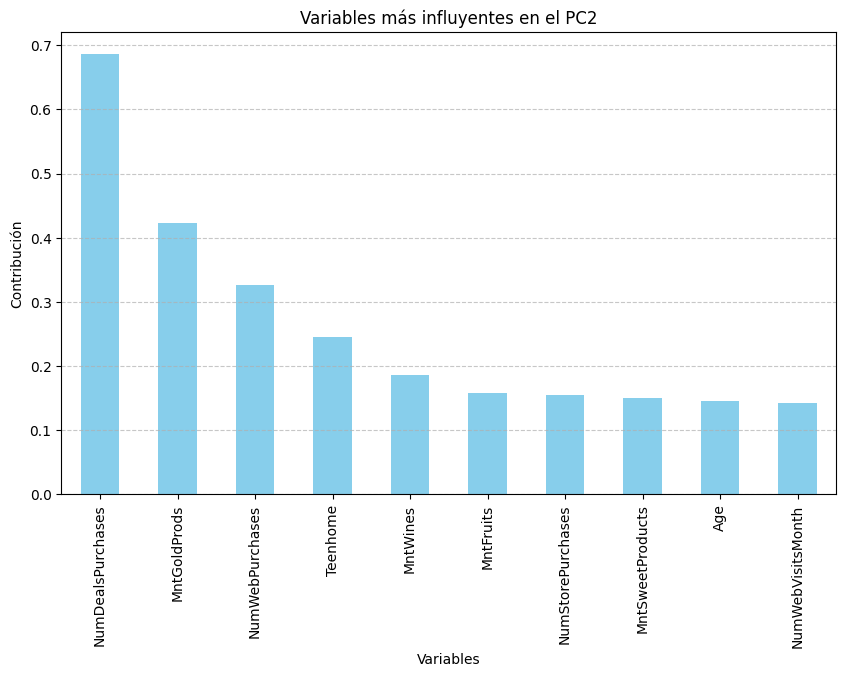

In [48]:
# Graficar las variables más influyentes por componente principal
for pc in componentes_df.index:
    # Graficar las variables más influyentes del primer componente
    plt.figure(figsize=(10, 6))
    componentes_df.loc[pc].sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
    plt.title(f'Variables más influyentes en el {pc}')
    plt.xlabel('Variables')
    plt.ylabel('Contribución')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

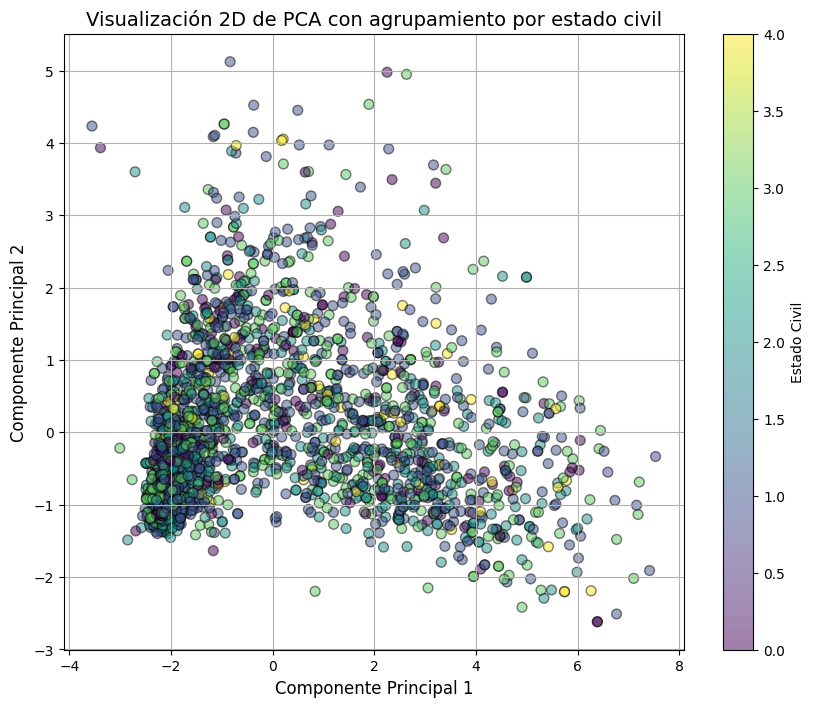

In [49]:
# Asumiendo que tienes las columnas 'Marital_Status_Married', 'Marital_Status_Single', etc. ya en el DataFrame
# Puedes agregar una variable para colorear según el estado civil de los clientes.

# Crear una columna de estado civil basado en las columnas de "Marital_Status"
df['Marital_Status'] = df[['Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single',
                           'Marital_Status_Together', 'Marital_Status_Widow']].idxmax(axis=1)

# Visualizar el agrupamiento por estado civil
plt.figure(figsize=(10, 8))
plt.scatter(RS_X_reduced[:, 0], RS_X_reduced[:, 1], c=df['Marital_Status'].astype('category').cat.codes, cmap='viridis', alpha=0.5, edgecolors='k', s=50)
plt.title('Visualización 2D de PCA con agrupamiento por estado civil', fontsize=14)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.colorbar(label='Estado Civil')
plt.grid(True)
plt.show()


Al aplicar PCA se logro la varianza al 90% pero al ver los dos primeros componentes no se ve una agrupación clara.

Le aplique el t-SNE mejoro un poco la visualización pero aún así no hay una clara agrupación, no se está capturando las relaciones internas del dataset.



Detalle de la varianza lograda en los dos primeros componentes.
*   Componente 1: 38.78% (38.78%)
*   Componente 2: 48.02% (9.23%)



Si agrupamos a los clientes en cuanto a su estado civil, TODOS consumen productos o las variables detalladas en los compomenentes 1 y 2.

Lo que llama la atención es que carnes tiene una menor influencia en el componente 1, esta en el cuarto lugar pero en cuanto a montos es de los primeros.

Esto puede ser a que es muy costoso y que los clientes lo compren menos y prefiean pescados, que es más barato.

**Variables más influyentes en PC1:**
- MntSweetProducts: 0.442320
- MntFruits: 0.425971
- MntFishProducts: 0.402110
- MntMeatProducts: 0.356036
- MntGoldProds: 0.287853

**Variables más influyentes en PC2:**
- NumDealsPurchases: 0.685943
- MntGoldProds: 0.422086
- NumWebPurchases: 0.325921
- Teenhome: 0.245124
- MntWines: 0.185925


In [50]:
# Estados civiles del df
df['Marital_Status'].value_counts()

,count
Marital_Status,
Marital_Status_Married,864
Marital_Status_Together,580
Marital_Status_Single,487
Marital_Status_Divorced,232
Marital_Status_Widow,77


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       2240 non-null   int64  
 1   Year_Birth               2240 non-null   int64  
 2   Education                2240 non-null   object 
 3   Marital_Status           2240 non-null   object 
 4   Income                   2240 non-null   float64
 5   Kidhome                  2240 non-null   int64  
 6   Teenhome                 2240 non-null   int64  
 7   Recency                  2240 non-null   int64  
 8   MntWines                 2240 non-null   int64  
 9   MntFruits                2240 non-null   int64  
 10  MntMeatProducts          2240 non-null   int64  
 11  MntFishProducts          2240 non-null   int64  
 12  MntSweetProducts         2240 non-null   int64  
 13  MntGoldProds             2240 non-null   int64  
 14  NumDealsPurchases       

In [52]:
# Hacemos un respaldo del df.
df_respaldo = df.copy()

# 3. Modelado con MLP:
Divide el dataset en conjuntos de entrenamiento y prueba, asegurándote de tener una proporción adecuada de cada clase en el conjunto de datos.


In [67]:
import pandas as pd

# Sumar todas las columnas de ventas de productos para obtener el total de ventas por cliente
productos_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Ventas'] = df[productos_columns].sum(axis=1)

# Definir los rangos para la clasificación del total de ventas
bins = [0, 99, 199, 499, float('inf')]  # Ajuste de los límites según las categorías solicitadas
labels = ['Baja', 'Media', 'Alta', 'Muy Alta']  # Etiquetas para cada rango

# Crear una nueva columna en el DataFrame con la clasificación del total de ventas
df['Clasificacion_Ventas'] = pd.cut(df['Total_Ventas'], bins=bins, labels=labels, right=True, include_lowest=True)

# Ver el DataFrame con la nueva columna
print(df[['Total_Ventas', 'Clasificacion_Ventas']].head())


   Total_Ventas Clasificacion_Ventas
0          1617             Muy Alta
1            27                 Baja
2           776             Muy Alta
3            53                 Baja
4           422                 Alta


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ID                       2240 non-null   int64   
 1   Year_Birth               2240 non-null   int64   
 2   Education                2240 non-null   object  
 3   Marital_Status           2240 non-null   object  
 4   Income                   2240 non-null   float64 
 5   Kidhome                  2240 non-null   int64   
 6   Teenhome                 2240 non-null   int64   
 7   Recency                  2240 non-null   int64   
 8   MntWines                 2240 non-null   int64   
 9   MntFruits                2240 non-null   int64   
 10  MntMeatProducts          2240 non-null   int64   
 11  MntFishProducts          2240 non-null   int64   
 12  MntSweetProducts         2240 non-null   int64   
 13  MntGoldProds             2240 non-null   int64   
 14  NumDeals

In [68]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Primero, separa las características (X) y la variable objetivo (y)
X = df.drop(columns=['Total_Ventas', 'Clasificacion_Ventas','Year_Birth','Income_Category','ID','Z_Revenue','Z_CostContact','Education','Marital_Status'])
y = df['Clasificacion_Ventas']

# Dividir el conjunto en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Aplicar SMOTE para equilibrar las clases en el conjunto de entrenamiento
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' para equilibrar todas las clases
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Ver las clases antes y después de SMOTE
print(f"Distribución de clases antes de SMOTE:\n{y_train.value_counts()}")
print(f"Distribución de clases después de SMOTE:\n{y_train_resampled.value_counts()}")

# Ahora, divide el conjunto temporal en validación y prueba (50% de cada uno)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Ver las dimensiones de los conjuntos
print(f"Entrenamiento balanceado: X_train_resampled = {X_train_resampled.shape}, y_train_resampled = {y_train_resampled.shape}")
print(f"Validación: X_valid = {X_valid.shape}, y_valid = {y_valid.shape}")
print(f"Prueba: X_test = {X_test.shape}, y_test = {y_test.shape}")


Distribución de clases antes de SMOTE:
Clasificacion_Ventas
Muy Alta    590
Baja        438
Alta        195
Media       121
Name: count, dtype: int64
Distribución de clases después de SMOTE:
Clasificacion_Ventas
Baja        590
Media       590
Alta        590
Muy Alta    590
Name: count, dtype: int64
Entrenamiento balanceado: X_train_resampled = (2360, 33), y_train_resampled = (2360,)
Validación: X_valid = (448, 33), y_valid = (448,)
Prueba: X_test = (448, 33), y_test = (448,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [77]:
# Cantidad de columnas del X_train_scaled
num_columns = X_train_resampled.shape[1]
print(f"Cantidad de columnas en X_train_scaled: {num_columns}")

Cantidad de columnas en X_train_scaled: 33


In [72]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Codificar la variable objetivo 'Clasificacion_Ventas' a números (en caso de que no se haya hecho)
label_encoder = LabelEncoder()
y_train_resampled_encoded = label_encoder.fit_transform(y_train_resampled)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

# Escalar las características (X) para que tengan una media de 0 y desviación estándar de 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo MLP
model = Sequential()

# Capa de entrada (asumiendo que hay un número de características X_train_scaled.shape[1])
# Uso 64 porque es el primer base 2 que supera a las 33 características. Es una fijacion que tengo, a la CPU le gusta esos numeros.
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))  # Capa de entrada con 64 neuronas
model.add(Dropout(0.3))  # Dropout para prevenir el sobreajuste

# Capa oculta
# Bajo a 32 porque la info de la primera capa ya viene condensada.
model.add(Dense(32, activation='relu'))  # Capa oculta con 32 neuronas.
model.add(Dropout(0.3))  # Dropout       # Probe con relu y me salio bien de una. Sino iba a ver si hay demasiados negativos que matasen neuronas  para ver Leaky ReLU

# Capa de salida (4 clases en la variable objetivo)
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Salida con 4 clases (según tu `Clasificacion_Ventas`)

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Configuración de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitorea la pérdida de validación
                               patience=10,  # Número de épocas sin mejora antes de detener el entrenamiento
                               restore_best_weights=True,  # Restaurar los pesos del modelo al mejor estado
                               verbose=1)
# Entrenar el modelo
history = model.fit(X_train_scaled, y_train_resampled_encoded, epochs=50, batch_size=32,callbacks=[early_stopping],
                    validation_data=(X_valid_scaled, y_valid_encoded), verbose=1)


# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded)
print(f'Loss en conjunto de prueba: {test_loss:.4f}, Accuracy en conjunto de prueba: {test_accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3233 - loss: 1.4401 - val_accuracy: 0.7522 - val_loss: 0.6974
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5992 - loss: 0.8743 - val_accuracy: 0.8192 - val_loss: 0.5051
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7121 - loss: 0.6666 - val_accuracy: 0.8795 - val_loss: 0.4226
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7634 - loss: 0.5698 - val_accuracy: 0.8817 - val_loss: 0.4077
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7962 - loss: 0.4837 - val_accuracy: 0.8795 - val_loss: 0.3925
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8260 - loss: 0.4148 - val_accuracy: 0.8996 - val_loss: 0.3691
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8363 - loss: 0.4006 - val_accuracy: 0.8951 - val_loss: 0.3771
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8423 - loss: 0.3669 - val_accuracy: 0.9062 - val_loss

# 4. Evaluación del modelo:

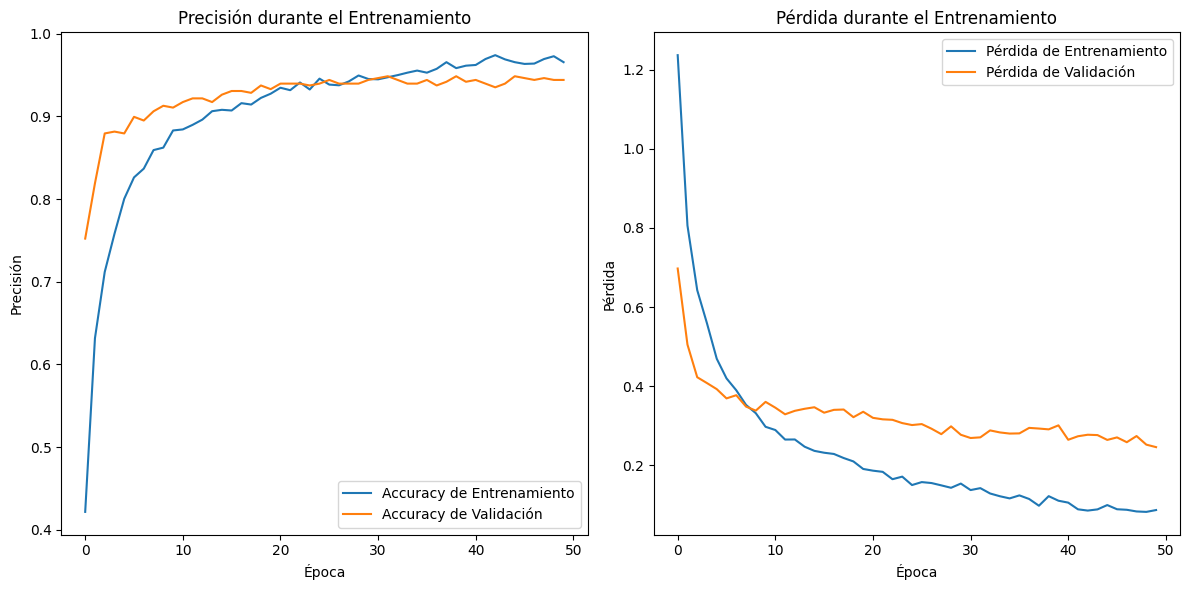

In [73]:
import matplotlib.pyplot as plt

# Graficar precisión
plt.figure(figsize=(12, 6))

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Graficar pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()


Al observar los graficos de Precisión y de Perdida se ve que tienen armonia los resultados de Entrenamiento y Test por lo que sugiere que no hay sobre ajuste en nuestro modelo.

La diferencia de las metricas en ambos graficos es mínima.

El modelo se ve que ha aprendido, no hay sobre ajuste.

Podemos avanzar con la predicción.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Reporte de clasificación para el conjunto de validación:
              precision    recall  f1-score   support

        Alta       0.90      0.92      0.91        72
        Baja       0.95      0.96      0.96       144
       Media       0.80      0.75      0.77        32
    Muy Alta       0.97      0.97      0.97       200

    accuracy                           0.94       448
   macro avg       0.91      0.90      0.90       448
weighted avg       0.94      0.94      0.94       448



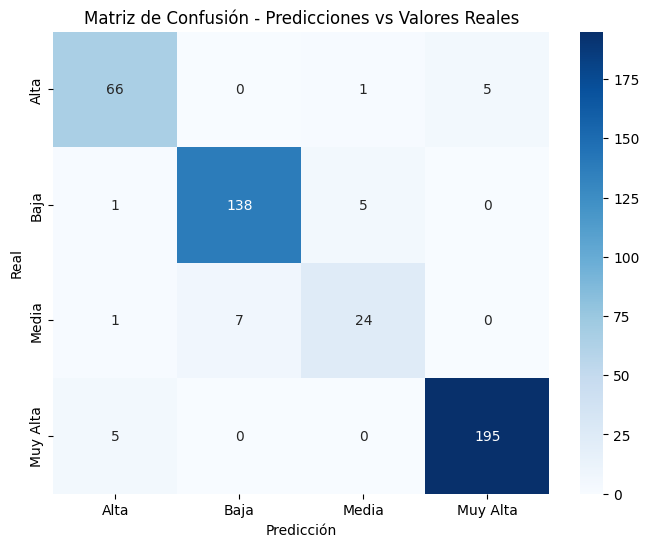

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Hacer predicciones sobre el conjunto de validación
y_valid_pred = model.predict(X_valid_scaled)

# Convertir las predicciones de vuelta a las clases originales
y_valid_pred_classes = label_encoder.inverse_transform(y_valid_pred.argmax(axis=1))

# Comparar las predicciones con los valores reales
print("Reporte de clasificación para el conjunto de validación:")
print(classification_report(y_valid, y_valid_pred_classes))

# Graficar la matriz de confusión
cm = confusion_matrix(y_valid, y_valid_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión - Predicciones vs Valores Reales")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))



La matriz de confusion nos muestra que para identificar los tipos de Gastos

Nuestro modelo tiene en f1 un 91% de acierto para los gastos Altos.

Para los extremos, Muy alta y Baja 97% y 96%.

Le cuesta un poco identificar la Media 77%: Las categorias aledañas le complican un poco: Toma gastos de Baja y Alta

# 5. Discusión y análisis:
  ## - Reflexiona sobre los resultados del análisis no supervisado y el modelo MLP. ¿Qué insights obtuviste de los clusters o los componentes principales?
  ## ¿Cómo se relacionan con el comportamiento de los clientes?
  ## - Discute el rendimiento del modelo MLP. ¿Es adecuado para este tipo de datos? ¿Cómo podrías mejorarlo?  
  Con respecto al PCA con el RobusScaler solo preciso 15 componentes para explicar la varianza al menos del 90%. Pero al ver como quedo en el espacio, no vi claramente separación entre los componentes. No logra exponer adecuadamente la agrupación. Creo que hay relaciones no lineales fuera del alcance del PCA.  

  Ante esta situción tuve que pensar en una nueva característica para poder predecir algo importante para este dataset. No me fue posible estimar gastos por productos. Entonces, se me ocurrio en sumar todas las ventas y segmentarlas por Baja, Media, Alta y Muy Alta y con esos sí pude tener unas predicciones mucho mejores.

  Me pareció necesario realizar un balanceo de las clases y al aplicar la nueva caracterpistica tuve un rendimiento general del 94%



# 6. Entrega final:
  – Entrega un informe detallado que incluya todas las etapas del examen: preprocesamiento de datos, análisis no supervisado, modelado MLP, evaluación del modelo y conclusiones. Asegúrate de que el informe sea claro y estructurado, con visualizaciones que apoyen tu análisis.
  
  ## Voy a adjuntar un PDF.